# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import re
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/europe-cities-31/cities.csv
/kaggle/input/cities-31/cities.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
# Подгружаю свой датасет с доп. данными по 31 городу
df_cities = pd.read_csv('/kaggle/input/cities-31/cities.csv')

In [6]:
df_cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 7 columns):
City                   31 non-null object
Население              31 non-null float64
Площадь                31 non-null float64
Уровень_жизни          31 non-null float64
Столица                31 non-null int64
Месячный_доход         31 non-null float64
Плотность населения    31 non-null float64
dtypes: float64(5), int64(1), object(1)
memory usage: 1.8+ KB


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [8]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [10]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [11]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [12]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [13]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [15]:
data.columns

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating'],
      dtype='object')

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

## 1. Обработка NAN 

In [16]:
# Добавляем столбец с информацией о пропусках в Number of Reviews
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [17]:
# Заполняю некоторые пропуски, большинство будет заполнено ниже
data['Cuisine Style'].fillna('Vegetarian Friendly', inplace=True) # самый часто повторяющийся вид кухни
data['Reviews'].fillna('', inplace=True)

In [18]:
data.sample(2)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN
41457,id_4969,Rome,['Italian'],4970.0,$$ - $$$,72.0,"[['Simple but Great value', 'Good spot for cas...",/Restaurant_Review-g187791-d4323991-Reviews-Ba...,d4323991,1,3.5,0
49351,id_1626,Lisbon,"['European', 'Portuguese']",1627.0,$$ - $$$,29.0,"[['Unique', 'Great Restaurant but Fairly Price...",/Restaurant_Review-g189158-d3570226-Reviews-O_...,d3570226,1,4.0,0


### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [19]:
data.nunique(dropna=False)

Restaurant_id              13094
City                          31
Cuisine Style              10732
Ranking                    12975
Price Range                    4
Number of Reviews           1574
Reviews                    41858
URL_TA                     49963
ID_TA                      49963
sample                         2
Rating                        10
Number_of_Reviews_isNAN        2
dtype: int64

In [20]:
# One-Hot Encoding - 31 город из City
data = pd.concat([data,pd.get_dummies(data['City'])],axis=1)

In [21]:
data.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,...,0,0,0,1,0,0,0,0,0,0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,...,0,0,0,0,0,0,0,0,0,0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,...,0,0,0,0,0,0,0,0,0,0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,...,0,0,0,0,0,0,0,0,0,0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich
2753,id_2753,London,"['Asian', 'Thai']",15346.0,$$ - $$$,53.0,"[['A very curry Christmas', 'First visit and p...",/Restaurant_Review-g186338-d1063172-Reviews-Pe...,d1063172,0,...,0,0,0,0,0,0,0,0,0,0
11940,id_2942,Brussels,Vegetarian Friendly,2940.0,NaN,2.0,"[['Not a good idea', ""Don't bother""], ['07/26/...",/Restaurant_Review-g188644-d10467508-Reviews-L...,d10467508,1,...,0,0,0,0,0,0,0,0,0,0
31644,id_3770,Milan,Vegetarian Friendly,3772.0,NaN,2.0,"[[], []]",/Restaurant_Review-g187849-d8338343-Reviews-Ca...,d8338343,1,...,0,0,0,0,0,0,0,0,0,0
16823,id_6060,Paris,"['French', 'European', 'Vegetarian Friendly']",6061.0,$$ - $$$,59.0,"[['Great crepes - cute place', 'Best crepe in ...",/Restaurant_Review-g187147-d10836293-Reviews-2...,d10836293,1,...,0,0,0,1,0,0,0,0,0,0
13406,id_71,Prague,"['Mediterranean', 'Italian', 'European', 'Vege...",72.0,$$ - $$$,751.0,"[['Amazing Italian!', 'New Years'], ['01/08/20...",/Restaurant_Review-g274707-d694914-Reviews-Cic...,d694914,1,...,0,0,0,0,1,0,0,0,0,0


По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  

In [23]:
# Работа над признаком Price Range - прохожусь словарем по элементам 
# + заполняю пропуски 0
dict_price = {
    '$$$$': 3, 
    '$$ - $$$': 2, 
    '$': 1
    }
data['Price Range'] = data['Price Range'].map(dict_price) 
data['Price Range'].fillna(0, inplace=True) 

In [24]:
# Обработка признака Cuisine Style (чистка от скобок и прочих символов)
# и формирование нового признака cuisine_count - число кухонь в ресторане
cuisine_list = []
df_list = []
data['cuisine_count'] = 1
for i in range(len(data['Cuisine Style'])):
    if type(data['Cuisine Style'][i]) is str:
        for x, y in ("[", ""), ("]", ""), ("[[", ""), ("]]",""):
            data['Cuisine Style'][i] = data[
                'Cuisine Style'][i].replace(x, y)
        df_list = data['Cuisine Style'][i].split(', ')
        lenght_i = len(df_list)
        data['cuisine_count'][i] = lenght_i
        for j in range(len(data['Cuisine Style'][i].split("', '"))):
            cuisine_list.append(df_list[j].strip("'"))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [25]:
# Ухудшает результаты работы модели! - не использую
# One-Hot обработка "своими руками" всех видов кухонь Cuisine_Style, 
# представленных во всех строках (125 кухонь)

# cuisine_set = set(cuisine_list) # list с кухнями преобразуем в set
# cuisine_list_set = list(cuisine_set) # вновь list для цикла
# for i in range(len(cuisine_set)):
#     data[cuisine_list_set[i]] = 0
# for i in range(len(data['Cuisine Style'])):
#     for j in range(len(cuisine_list_set)):
#         if cuisine_list_set[j] in data['Cuisine Style'][i]:
#             data[cuisine_list_set[j]][i] = 1

In [26]:
# Обработка признака Reviews с дальнейшей обработкой дат
# если значение отстутствует - отметка об этом в Reviews_isNAN
df_list_2 = []
data['date_1_review'] = 0 # дней от 1 отзыва до текущей даты
data['date_2_review'] = 0 # дней от 2 отзыва до текущей даты
data['date_review_diff'] = 0 # разница в днях между 2 отзывами
data['Reviews_isNAN'] = 0 # информация о пропущенных значениях
data['days_to_now'] = 0 # значение в днях до текущей даты
NOW = datetime.now() # текущее время
for i in range(len(data['Reviews'])):
    for x, y in ("[", ""), ("]", ""), ("[[", ""), ("]]",""):
        """Чистим Reviews от лишних символов, определяем vars"""
        data['Reviews'][i] = data['Reviews'][i].replace(x, y)
    df_list_2 = data['Reviews'][i].split("', '")
    for j in range(len(df_list_2)):
        df_list_2[j] = df_list_2[j].strip("'")
    if len(df_list_2) == 4: # проверка на 2 отзыва в Reviews
        dt1 = datetime.strptime(df_list_2[2], '%m/%d/%Y')
        dt2 = datetime.strptime(df_list_2[3], '%m/%d/%Y')
        diff = dt2 - dt1
        days_1 = abs((dt1 - NOW).days)
        days_2 = abs((dt2 - NOW).days)
        data['days_to_now'][i] = min(days_1, days_2)
        data['date_review_diff'][i] = abs(diff.days)
        data['date_1_review'][i] = days_1
        data['date_2_review'][i] = days_2
    if len(df_list_2) == 2: # проверка на только 1 отзыв в Reviews
        dt1 = datetime.strptime(df_list_2[1], '%m/%d/%Y')
        data['days_to_now'][i] = abs((dt1 - NOW).days)
        data['date_1_review'][i] = abs((dt1 - NOW).days)
    if len(data['Reviews'][i]) < 10: 
        # если строка короткая - значит необходимо отметить в isNAN
        data['Reviews_isNAN'][i] = 1

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value

In [27]:
# Работа со статистическими данными по городам
df_007 = pd.DataFrame() # новый датафрейм
df_007['Mean_Reviews_in_town'] = data.groupby('City')[
    'Number of Reviews'].mean() 
df_007['Count_Reviews_in_town'] = data.groupby('City')[
    'Number of Reviews'].sum() / 10000
df_007['Mean_date_diff_in_town'] = data.groupby('City')[
    'date_review_diff'].mean()
df_007['Count_rest_in_town'] = data.groupby('City')[
    'City'].count()
df_007['Mean_date_1_in_town'] = data.groupby('City')[
    'date_1_review'].mean()
df_007['Mean_date_2_in_town'] = data.groupby('City')[
    'date_2_review'].mean()
df_007['Mean_days_to_now'] = data.groupby('City')[
    'days_to_now'].mean()
df_007['Mean_Ranking_in_town'] = data.groupby('City')[
    'Ranking'].mean()
df_007['Sum_Ranking_in_town'] = data.groupby('City')[
    'Ranking'].sum()

In [28]:
# Объединяем датафреймы по столбцу City
data = data.merge(df_007, on='City', how='left')

In [29]:
# Заполняем остальные пропуски средними значениями признаков
for i in range(len(data['City'])):
    if pd.isna(data['Number of Reviews'][i]):
        data['Number of Reviews'][i] = data['Mean_Reviews_in_town'][i]
    if data['date_review_diff'][i] == 0:
        data['date_review_diff'][i] = data['Mean_date_diff_in_town'][i]
    if data['date_2_review'][i] == 0:
        data['date_2_review'][i] = data['Mean_date_2_in_town'][i]
    if data['date_1_review'][i] == 0:
        data['date_1_review'][i] = data['Mean_date_1_in_town'][i]
    if data['days_to_now'][i] == 0:
        data['days_to_now'][i] = data['Mean_days_to_now'][i]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher

In [30]:
# Объединяем датафрейм с новым датафреймом 
# с информацией о 31 городе из столбца City
data = data.merge(df_cities, on='City', how='left')

In [31]:
# Формируем новые признаки на основе имеющихся
# Физический смысл многих отсутствует
data['Rank_in_town_new'] = data['Count_rest_in_town'] / data['Ranking']
data['Mean_Rank_Count_rest'] = (data['Mean_Ranking_in_town']/
                                data['Count_rest_in_town'])
data['Mean_Rank_to_Rank'] = (data['Mean_Ranking_in_town']/
                             data['Ranking'])
data['Otnosit_Rank_town'] = ((data['Count_rest_in_town'] -
                             data['Ranking'])/
                            data['Count_rest_in_town'] - 1)
data['Otnosit_Rank_to_mean'] = ((data['Mean_Ranking_in_town'] -
                                 data['Ranking'])/
                                data['Mean_Ranking_in_town'])
data['Otnosit_Reviews_to_mean'] = ((data['Number of Reviews'] -
                                    data['Mean_Reviews_in_town'])/
                                   data['Mean_Reviews_in_town'])
data['Sum_Ranking_in_town'] = data['Sum_Ranking_in_town'] / \
                              10000000
data['Plotn_Otnosit_Rank_town'] = data['Плотность населения'] / \
                                  data['Otnosit_Rank_town'] 
data['Otnosit_Rank_town_NoR'] = data['Otnosit_Rank_town'] * \
                                data['Number of Reviews'] 
data['Otnosit_Rant_mean_NoR'] = data['Otnosit_Rank_to_mean'] * \
                                data['Number of Reviews'] 
data['NoR_Ranking'] = data['Number of Reviews'] / \
                      data['Ranking']

In [32]:
# Убираем снижающие эффективность модели признаки
data.drop(['Mean_date_1_in_town'], axis = 1, inplace=True)
data.drop(['Mean_Reviews_in_town'], axis = 1, inplace=True)
data.drop(['Restaurant_id','ID_TA'], axis = 1, inplace=True)
data.drop(['Площадь'], axis = 1, inplace=True)

In [33]:
data.columns

Index(['City', 'Cuisine Style', 'Ranking', 'Price Range', 'Number of Reviews',
       'Reviews', 'URL_TA', 'sample', 'Rating', 'Number_of_Reviews_isNAN',
       'Amsterdam', 'Athens', 'Barcelona', 'Berlin', 'Bratislava', 'Brussels',
       'Budapest', 'Copenhagen', 'Dublin', 'Edinburgh', 'Geneva', 'Hamburg',
       'Helsinki', 'Krakow', 'Lisbon', 'Ljubljana', 'London', 'Luxembourg',
       'Lyon', 'Madrid', 'Milan', 'Munich', 'Oporto', 'Oslo', 'Paris',
       'Prague', 'Rome', 'Stockholm', 'Vienna', 'Warsaw', 'Zurich',
       'cuisine_count', 'date_1_review', 'date_2_review', 'date_review_diff',
       'Reviews_isNAN', 'days_to_now', 'Count_Reviews_in_town',
       'Mean_date_diff_in_town', 'Count_rest_in_town', 'Mean_date_2_in_town',
       'Mean_days_to_now', 'Mean_Ranking_in_town', 'Sum_Ranking_in_town',
       'Население', 'Уровень_жизни', 'Столица', 'Месячный_доход',
       'Плотность населения', 'Rank_in_town_new', 'Mean_Rank_Count_rest',
       'Mean_Rank_to_Rank', 'Otnosit_Rank

In [34]:
data.sample(10)

,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,sample,Rating,Number_of_Reviews_isNAN,...,Rank_in_town_new,Mean_Rank_Count_rest,Mean_Rank_to_Rank,Otnosit_Rank_town,Otnosit_Rank_to_mean,Otnosit_Reviews_to_mean,Plotn_Otnosit_Rank_town,Otnosit_Rank_town_NoR,Otnosit_Rant_mean_NoR,NoR_Ranking
35307,Milan,"'Japanese', 'Seafood', 'Sushi', 'Asian', 'Soup...",913.0,2.0,362.0,"'Authentic traditional Japanese cuisine.', 'go...",/Restaurant_Review-g187849-d2386060-Reviews-En...,1,4.0,0,...,2.950712,1.152943,3.402002,-0.338901,0.706055,1.150935,-223.522752,-122.682257,255.592068,0.396495
1797,Milan,Vegetarian Friendly,3943.0,0.0,9.0,'Good stop for gelato as you explore the Na......,/Restaurant_Review-g187849-d10862809-Reviews-G...,0,0.0,0,...,0.683236,1.152943,0.787732,-1.463623,-0.269467,-0.946524,-51.756600,-13.172606,-2.425203,0.002283
20593,Berlin,'Vegetarian Friendly',539.0,2.0,55.0,"'Yummy', 'Wonderful place, good food', '12/02/...",/Restaurant_Review-g187323-d1344179-Reviews-Ma...,1,4.5,0,...,5.018553,1.203482,6.039736,-0.199261,0.834430,-0.137555,-205.064484,-10.959335,45.893642,0.102041
49881,Paris,"'French', 'Japanese'",6774.0,2.0,9.0,"'Just awesome', 'A must try in Paris', '07/06/...",/Restaurant_Review-g187147-d12535525-Reviews-R...,1,4.5,0,...,0.901683,1.135979,1.024292,-1.109037,0.023716,-0.923104,-184.486641,-9.981336,0.213447,0.001329
29228,Barcelona,'Mediterranean',7702.0,0.0,3.0,",",/Restaurant_Review-g187497-d7341143-Reviews-Ja...,1,1.5,0,...,0.440795,1.142687,0.503690,-2.268630,-0.985347,-0.977890,-72.629944,-6.805891,-2.956041,0.000390
20263,London,"'Indian', 'Asian', 'Balti', 'Bangladeshi', 'Ea...",15467.0,2.0,96.0,"'Mediocre at best', 'Lunch', '02/01/2017', '05...",/Restaurant_Review-g186338-d8448187-Reviews-Ga...,1,3.0,0,...,0.465055,1.135786,0.528202,-2.150285,-0.893213,-0.304188,-26.512815,-206.427360,-85.748493,0.006207
14834,Prague,"'International', 'European', 'Czech', 'Central...",545.0,2.0,111.0,"'Deer Saddle and Wild Boar', 'Just Sufficient ...",/Restaurant_Review-g274707-d11951567-Reviews-D...,1,4.0,0,...,3.332110,1.149218,3.829320,-0.300110,0.738857,-0.107557,-89.690461,-33.312225,82.013133,0.203670
8310,Munich,"'Middle Eastern', 'Persian', 'Halal', 'Vegetar...",728.0,2.0,61.0,"'kind of oriental flair good simple food', 'Ex...",/Restaurant_Review-g187309-d742677-Reviews-Deh...,0,0.0,0,...,1.572802,1.196767,1.882277,-0.635808,0.468729,-0.214417,-74.417718,-38.784279,28.592446,0.083791
18093,Barcelona,Vegetarian Friendly,5399.0,0.0,5.0,"'Not bad', '08/04/2015'",/Restaurant_Review-g187497-d5614420-Reviews-La...,1,4.0,0,...,0.628820,1.142687,0.718545,-1.590280,-0.391702,-0.963149,-103.611008,-7.951399,-1.958510,0.000926
22332,Athens,Vegetarian Friendly,1376.0,0.0,15.0,"'Voodoo-ing', 'Good bar but', '11/24/2017', '0...",/Restaurant_Review-g189400-d3709223-Reviews-Vo...,1,3.5,0,...,0.563953,1.134296,0.639690,-1.773196,-0.563256,-0.840404,-9.089589,-26.597938,-8.448845,0.010901


# EDA 

### Посмотрим распределение признака

# Визуализировать будем новый датафрейм - тренировочная часть с учетом новых признаков

In [35]:
df_train_new = data.query('sample == 1')

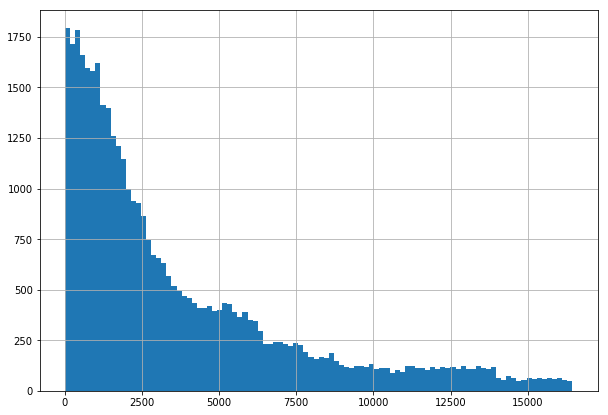

In [36]:
plt.rcParams['figure.figsize'] = (10,7)
df_train_new['Ranking'].hist(bins=100);

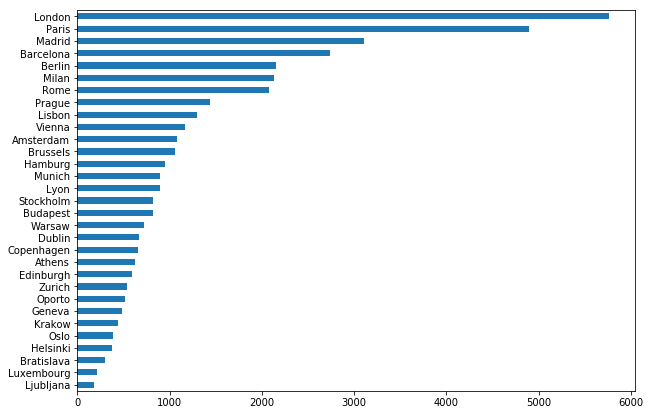

In [37]:
df_train_new['City'].value_counts(ascending=True).plot(kind='barh');

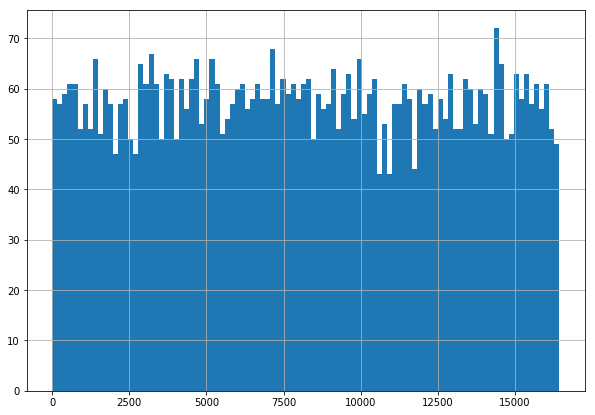

In [38]:
df_train_new['Ranking'][df_train_new['City'] =='London'].hist(bins=100);

Проанализируем введенные новые признаки (Mean_Rank_to_Rank - средний ранк в городе к ранку ресторана)

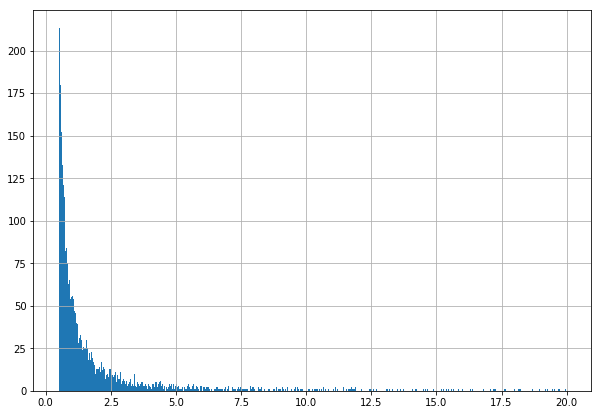

In [39]:
df_train_new.query('City == "London" & Mean_Rank_to_Rank < 20')['Mean_Rank_to_Rank'].hist(bins=1000);

In [40]:
# Создаем датафрейм для визуализации с учетом np.log() от признак
df_visual = df_train_new.copy()

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


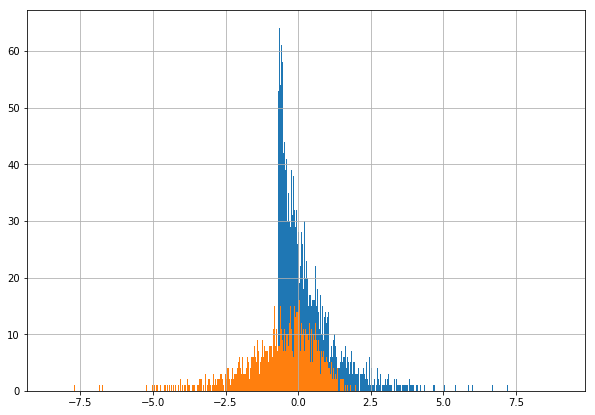

In [41]:
# По виду распределения кажется, что оно логарифмически нормальное 
df_visual['Mean_Rank_to_Rank'] = np.log(df_train_new['Mean_Rank_to_Rank'])
log_1 = df_visual.query(
                'City == "London" & Mean_Rank_to_Rank < 20'
                )['Mean_Rank_to_Rank'].hist(bins=1000);
# Возьмем еще раз логарифм - тогда распределение становится нормальным
df_visual['Mean_Rank_to_Rank'] = np.log(df_visual['Mean_Rank_to_Rank'])
log_2 = df_visual.query(
                'City == "London" & Mean_Rank_to_Rank < 20'
                )['Mean_Rank_to_Rank'].hist(bins=1000);

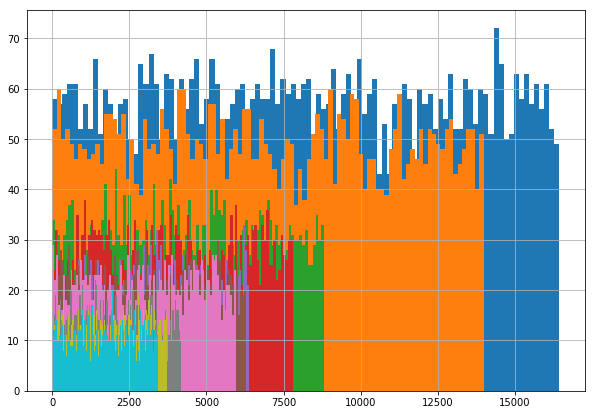

In [42]:
# посмотрим на топ 10 городов
for x in (df_train_new['City'].value_counts())[0:10].index:
    df_train_new['Ranking'][df_train_new['City'] == x].hist(bins=100);
plt.show()

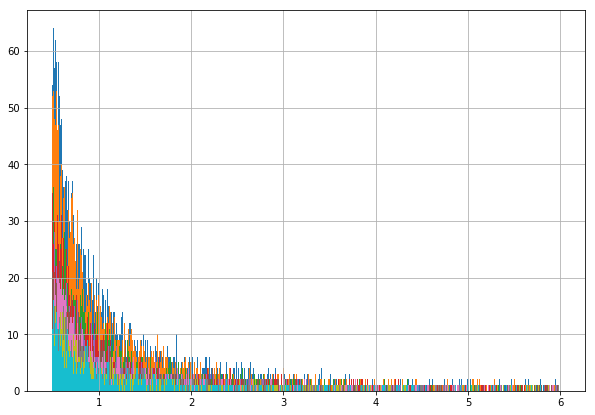

In [43]:
# посмотрим на топ 10 городов
for x in (df_train_new['City'].value_counts())[0:10].index:
    df_train_new['Mean_Rank_to_Rank'][(df_train_new['City'] == x) & (df_train_new['Mean_Rank_to_Rank'] < 6)].hist(bins=1000);
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.


## Вывод - значит, что относительные величины, которые увязывают значение Ранка со средним значением ранка в городе и другие, распределены нормально (при взятии 2 раз логарифма от признака) и дают более объективную связь. Таким образом, ввод в модель признаков относительных оценок позволяет нормировать взаимосвязь между Ранком в соответствии с городом, вне зависимости от того, сколько ресторанов представлено в городе в изначальном датафрейме.

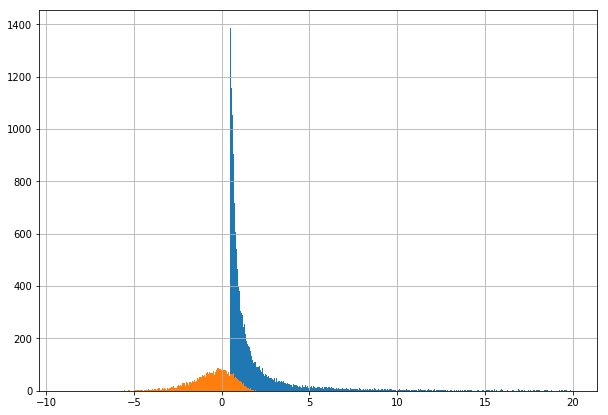

In [44]:
# df_vusial имеет признак Mean_Rank_to_Rank с учетом взятия 
# 2 раз логарифма
df_train_new.query('Mean_Rank_to_Rank < 20')['Mean_Rank_to_Rank'].hist(bins=1000);
df_visual.query('Mean_Rank_to_Rank < 20')['Mean_Rank_to_Rank'].hist(bins=1000);

### Посмотрим распределение целевой переменной

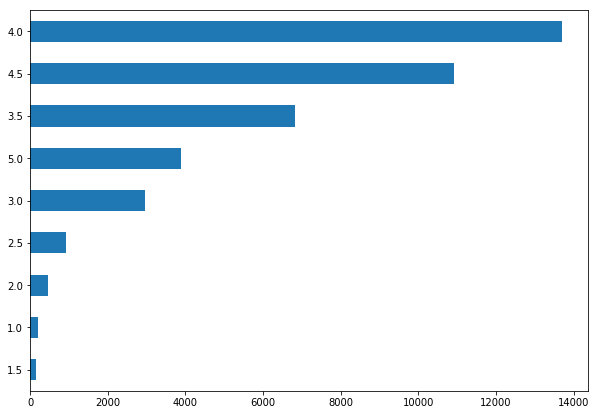

In [45]:
df_train_new['Rating'].value_counts(ascending=True).plot(kind='barh');

### Посмотрим распределение целевой переменной относительно признака

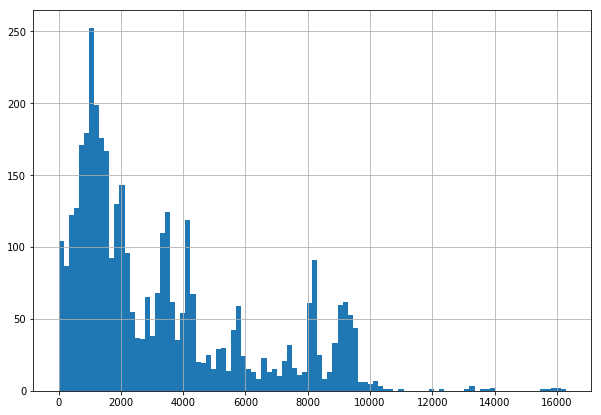

In [46]:
df_train_new['Ranking'][df_train_new['Rating'] == 5].hist(bins=100);

8169.707354372306

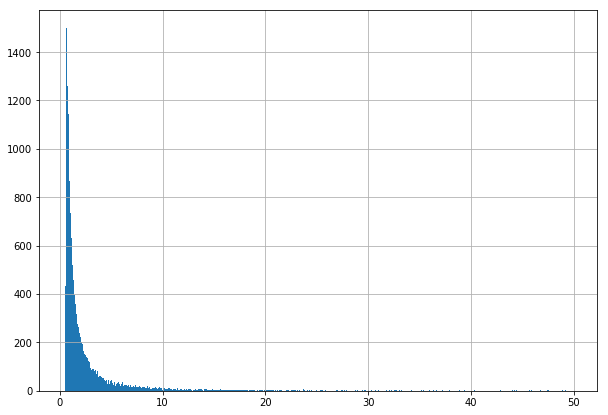

In [47]:
df_train_new.query('Rating >= 4 & Mean_Rank_to_Rank < 50')['Mean_Rank_to_Rank'].hist(bins=1000);
df_train_new.query('Rating >= 4')['Mean_Rank_to_Rank'].max()

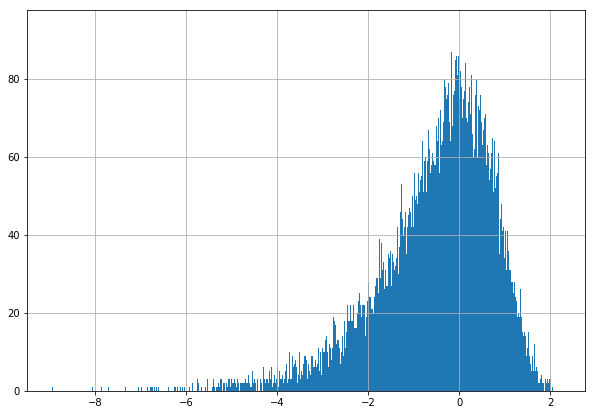

In [48]:
# С учетом взятия 2 раз логарифма от 'Mean_Rank_to_Rank'
df_visual.query('Rating >= 4 & Mean_Rank_to_Rank < 50')['Mean_Rank_to_Rank'].hist(bins=1000);

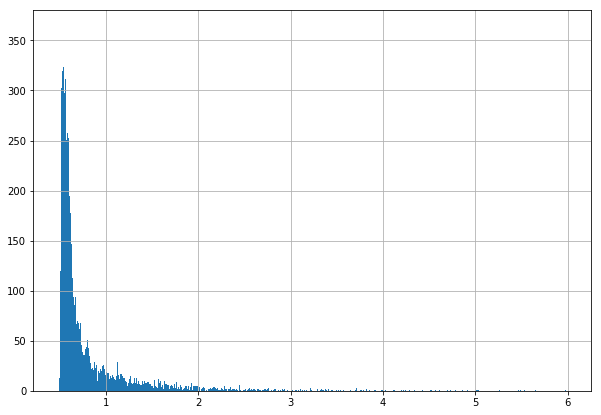

In [49]:
df_train_new.query('2 < Rating <= 3.5 & Mean_Rank_to_Rank < 6')['Mean_Rank_to_Rank'].hist(bins=1000);

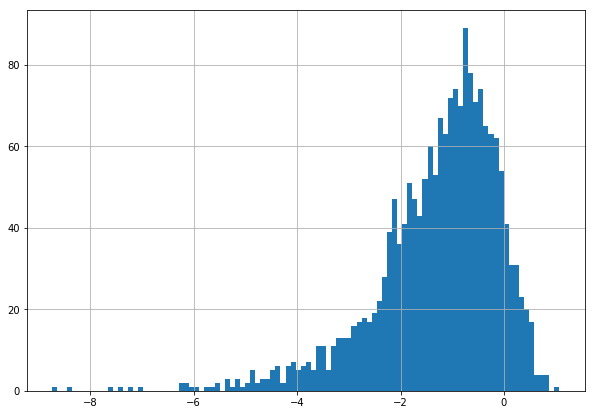

In [50]:
# С учетом взятия 2 раз логарифма от 'Mean_Rank_to_Rank'
df_visual.query('2 < Rating <= 3.5 & Mean_Rank_to_Rank < 6')['Mean_Rank_to_Rank'].hist(bins=100);

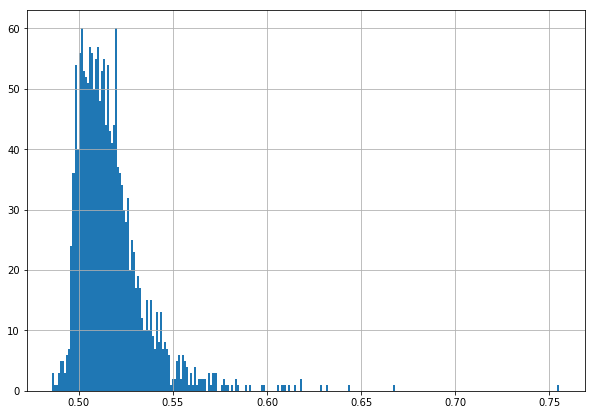

In [51]:
df_train_new.query('0 < Rating <= 2.5')['Mean_Rank_to_Rank'].hist(bins=250);

## Вывод по результатам анализа значения величины Mean_Rank_to_Rank: При низком рейтинге ресторана (например, от 3 и ниже) значение величины находится в пределах от 0.5 до 2. Чем выше рейтинг ресторана, следовательно ниже его Ранк, следовательно данная относительная оценка - становится все больше (например, при рейтинге от 4 и выше - доходит до нескольких тысяч (max - 8169).

Сам по себе показатель Ranking - довольно не информативный показатель. Однако, при наличии его в модели результаты МАЕ ниже, чем при его отсутствии. Все-таки, для физической интерпретации и понимания гораздо полезнее оперировать относительными или средними оценками. Они добавлены в достаточном количестве (полагаю, даже в излишнем, но все равно они повышают результат МАЕ).

С учетом взятия 2 раз логарифма от величины Mean_Rank_to_Rank - распределение становится похожим на нормальное.

## Аналогично Ранку рассмотрим распределение числа отзывов и относительной величины

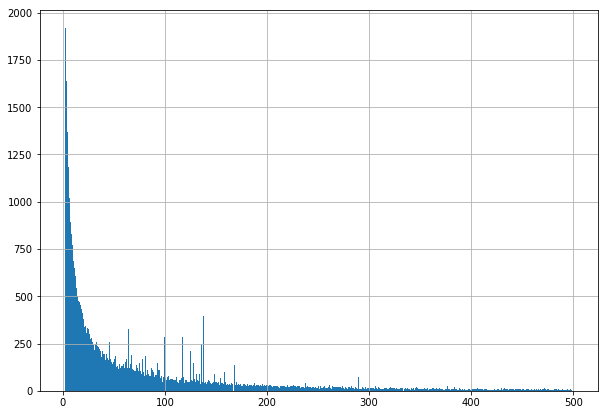

In [52]:
df_train_new['Number of Reviews'][df_train_new['Number of Reviews'] < 500].hist(bins=500);

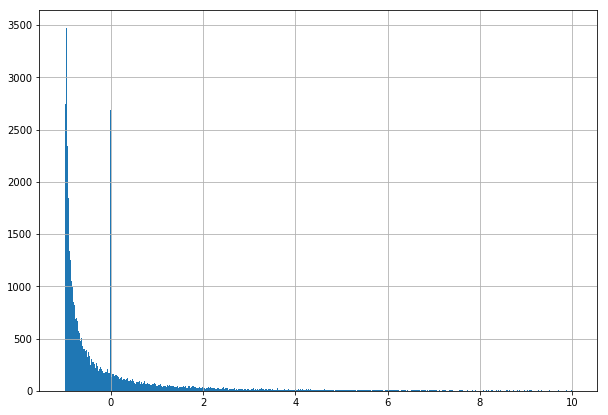

In [53]:
df_train_new['Otnosit_Reviews_to_mean'][df_train_new['Otnosit_Reviews_to_mean'] < 10].hist(bins=500);

Общий вид распределения "Number of Reviews" и "Otnosit_Reviews_to_mean" одинаковый, единственное - что значения в относительном варианте колеблются в меньшем диапазоне, что, по-моему мнению, положительно влияет на вычислительную точность модели и результате МАЕ. Аналогично по городам.

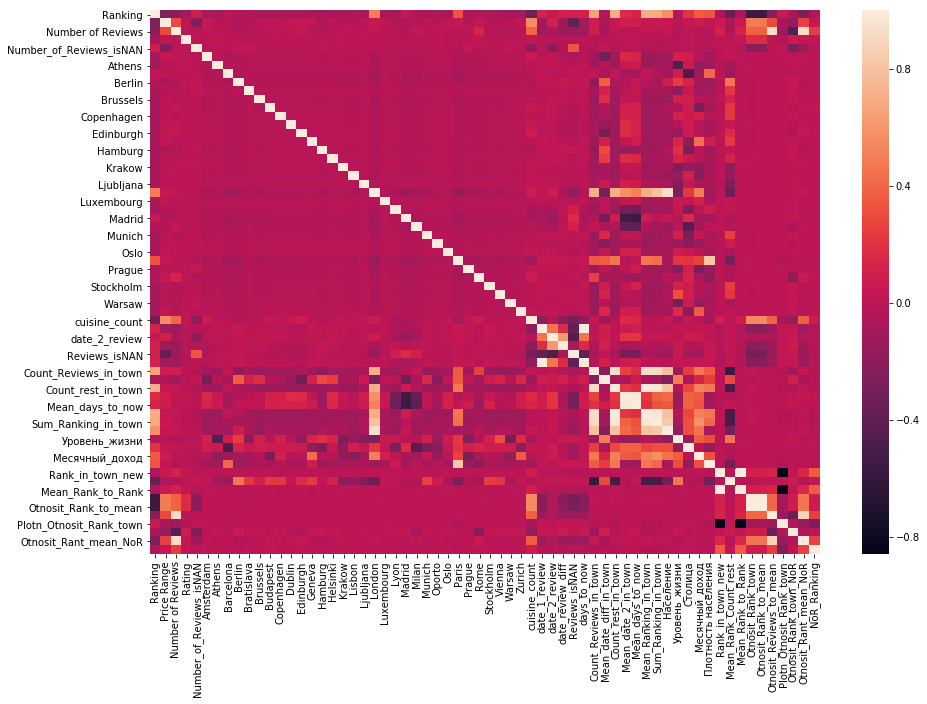

In [54]:
# Корреляция признаков
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),);

# На представленной таблице корреляции (тепловой карте) видны несколько обратнопропорциональных признаков в правой нижней части (черные клетки). Однако, при проведении экспериментов по чистке взаимозависимых признаков из модели выяснилось, что вычленение данных признаков из модели - увеличивает абсолютную ошибку МАЕ. Кроме того, насколько полагаю, в задаче, которая не является задачей линейной регрессии, сильно скоррелированные признаки не оказывают сильного пагубного воздействия на результаты.

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [55]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_cities = pd.read_csv('/kaggle/input/cities-31/cities.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [56]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # Добавляем столбец с информацией о пропусках в Number of Reviews
    df_output['Number_of_Reviews_isNAN'] = pd.isna(
        df_output['Number of Reviews']).astype('uint8')
    
    # Заполняю некоторые пропуски, большинство будет заполнено ниже
    df_output['Cuisine Style'].fillna('Vegetarian Friendly', inplace=True) 
    df_output['Reviews'].fillna('', inplace=True)
    
    # One-Hot Encoding - 31 город из City
    df_output = pd.concat([df_output,pd.get_dummies(df_output['City'])],axis=1)
    
    # Работа над признаком Price Range - прохожусь словарем по элементам 
    # + заполняю пропуски 0
    dict_price = {
        '$$$$': 3, 
        '$$ - $$$': 2, 
        '$': 1
        }
    df_output['Price Range'] = df_output['Price Range'].map(dict_price) 
    df_output['Price Range'].fillna(0, inplace=True) 
    
    # Обработка признака Cuisine Style (чистка от скобок и прочих символов)
    # и формирование нового признака cuisine_count - число кухонь в ресторане
    cuisine_list = []
    df_list = []
    df_output['cuisine_count'] = 1
    for i in range(len(df_output['Cuisine Style'])):
        if type(df_output['Cuisine Style'][i]) is str:
            for x, y in ("[", ""), ("]", ""), ("[[", ""), ("]]",""):
                df_output['Cuisine Style'][i] = df_output[
                    'Cuisine Style'][i].replace(x, y)
            df_list = df_output['Cuisine Style'][i].split(', ')
            lenght_i = len(df_list)
            df_output['cuisine_count'][i] = lenght_i
            for j in range(len(df_output['Cuisine Style'][i].split("', '"))):
                cuisine_list.append(df_list[j].strip("'"))
    
    
    # Обработка признака Reviews с дальнейшей обработкой дат
    # если значение отстутствует - отметка об этом в Reviews_isNAN
    df_list_2 = []
    df_output['date_1_review'] = 0 # дней от 1 отзыва до текущей даты
    df_output['date_2_review'] = 0 # дней от 2 отзыва до текущей даты
    df_output['date_review_diff'] = 0 # разница в днях между 2 отзывами
    df_output['Reviews_isNAN'] = 0 # информация о пропущенных значениях
    df_output['days_to_now'] = 0 # значение в днях до текущей даты
    NOW = datetime.now() # текущее время
    for i in range(len(df_output['Reviews'])):
        for x, y in ("[", ""), ("]", ""), ("[[", ""), ("]]",""):
            """Чистим Reviews от лишних символов, определяем vars"""
            df_output['Reviews'][i] = df_output['Reviews'][i].replace(x, y)
        df_list_2 = df_output['Reviews'][i].split("', '")
        for j in range(len(df_list_2)):
            df_list_2[j] = df_list_2[j].strip("'")
        if len(df_list_2) == 4: # проверка на 2 отзыва в Reviews
            dt1 = datetime.strptime(df_list_2[2], '%m/%d/%Y')
            dt2 = datetime.strptime(df_list_2[3], '%m/%d/%Y')
            diff = dt2 - dt1
            days_1 = abs((dt1 - NOW).days)
            days_2 = abs((dt2 - NOW).days)
            df_output['days_to_now'][i] = min(days_1, days_2)
            df_output['date_review_diff'][i] = abs(diff.days)
            df_output['date_1_review'][i] = days_1
            df_output['date_2_review'][i] = days_2
        if len(df_list_2) == 2: # проверка на только 1 отзыв в Reviews
            dt1 = datetime.strptime(df_list_2[1], '%m/%d/%Y')
            df_output['days_to_now'][i] = abs((dt1 - NOW).days)
            df_output['date_1_review'][i] = abs((dt1 - NOW).days)
        if len(df_output['Reviews'][i]) < 10: 
        # если строка короткая - значит необходимо отметить в isNAN
            df_output['Reviews_isNAN'][i] = 1
    
    # Работа со статистическими данными по городам
    df_007 = pd.DataFrame() # новый датафрейм
    df_007['Mean_Reviews_in_town'] = df_output.groupby('City')[
        'Number of Reviews'].mean() 
    df_007['Count_Reviews_in_town'] = df_output.groupby('City')[
        'Number of Reviews'].sum() / 10000
    df_007['Mean_date_diff_in_town'] = df_output.groupby('City')[
        'date_review_diff'].mean()
    df_007['Count_rest_in_town'] = df_output.groupby('City')[
        'City'].count()
    df_007['Mean_date_1_in_town'] = df_output.groupby('City')[
        'date_1_review'].mean()
    df_007['Mean_date_2_in_town'] = df_output.groupby('City')[
        'date_2_review'].mean()
    df_007['Mean_days_to_now'] = df_output.groupby('City')[
        'days_to_now'].mean()
    df_007['Mean_Ranking_in_town'] = df_output.groupby('City')[
        'Ranking'].mean()
    df_007['Sum_Ranking_in_town'] = df_output.groupby('City')[
        'Ranking'].sum()
    
    # Объединяем датафреймы по столбцу City
    df_output = df_output.merge(df_007, on='City', how='left')
    
    # Заполняем остальные пропуски средними значениями признаков
    for i in range(len(df_output['City'])):
        if pd.isna(df_output['Number of Reviews'][i]):
            df_output['Number of Reviews'][i] = \
            df_output['Mean_Reviews_in_town'][i]
        if df_output['date_review_diff'][i] == 0:
            df_output['date_review_diff'][i] = \
            df_output['Mean_date_diff_in_town'][i]
        if df_output['date_2_review'][i] == 0:
            df_output['date_2_review'][i] = \
            df_output['Mean_date_2_in_town'][i]
        if df_output['date_1_review'][i] == 0:
            df_output['date_1_review'][i] = \
            df_output['Mean_date_1_in_town'][i]
        if df_output['days_to_now'][i] == 0:
            df_output['days_to_now'][i] = \
            df_output['Mean_days_to_now'][i]
    
    # Объединяем датафрейм с новым датафреймом 
    # с информацией о 31 городе из столбца City
    df_output = df_output.merge(df_cities, on='City', how='left')
    
    # Формируем новые признаки на основе имеющихся
    # Физический смысл многих отсутствует
    df_output['Rank_in_town_new'] = \
        df_output['Count_rest_in_town'] / \
        df_output['Ranking']
    df_output['Mean_Rank_Count_rest'] = \
        df_output['Mean_Ranking_in_town'] / \
        df_output['Count_rest_in_town']
    df_output['Mean_Rank_to_Rank'] = \
        df_output['Mean_Ranking_in_town'] / df_output['Ranking']
    df_output['Otnosit_Rank_town'] = (
        (df_output['Count_rest_in_town'] - \
         df_output['Ranking']) / \
        df_output['Count_rest_in_town'] - 1)
    df_output['Otnosit_Rank_to_mean'] = (
        (df_output['Mean_Ranking_in_town'] - \
         df_output['Ranking']) / \
        df_output['Mean_Ranking_in_town'])
    df_output['Otnosit_Reviews_to_mean'] = (
        (df_output['Number of Reviews'] - \
         df_output['Mean_Reviews_in_town']) / \
        df_output['Mean_Reviews_in_town'])
    df_output['Sum_Ranking_in_town'] = \
        df_output['Sum_Ranking_in_town'] / 10000000
    df_output['Plotn_Otnosit_Rank_town'] = \
        df_output['Плотность населения'] / \
        df_output['Otnosit_Rank_town'] 
    df_output['Otnosit_Rank_town_NoR'] = \
        df_output['Otnosit_Rank_town'] * \
        df_output['Number of Reviews'] 
    df_output['Otnosit_Rant_mean_NoR'] = \
        df_output['Otnosit_Rank_to_mean'] * \
        df_output['Number of Reviews'] 
    df_output['NoR_Ranking'] = \
        df_output['Number of Reviews'] / \
        df_output['Ranking']
    
    # Убираем снижающие эффективность модели признаки
    df_output.drop(['Mean_date_1_in_town'], axis = 1, inplace=True)
    df_output.drop(['Mean_Reviews_in_town'], axis = 1, inplace=True)
    df_output.drop(['Restaurant_id','ID_TA'], axis = 1, inplace=True)
    df_output.drop(['Площадь'], axis = 1, inplace=True)
    
    
    # ################### 1. Предобработка ###################################
    # убираем не нужные для модели признаки
    
    # ################### 2. NAN ###################################################
    # Далее заполняем пропуски, 
    
    # ################### 3. Encoding ##############################################
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. 
    # Особенно радует параметр dummy_na
    # df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
   
    # ################### 4. Feature Engineering ###################################
    # тут ваш код не генерацию новых фитчей
    
    # ################### 5. Clean ###################################################
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто их удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

#### Запускаем и проверяем что получилось

In [57]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be s

,Ranking,Price Range,Number of Reviews,sample,Rating,Number_of_Reviews_isNAN,Amsterdam,Athens,Barcelona,Berlin,...,Rank_in_town_new,Mean_Rank_Count_rest,Mean_Rank_to_Rank,Otnosit_Rank_town,Otnosit_Rank_to_mean,Otnosit_Reviews_to_mean,Plotn_Otnosit_Rank_town,Otnosit_Rank_town_NoR,Otnosit_Rant_mean_NoR,NoR_Ranking
6910,1227.0,0.0,134.148581,0,0.0,1,0,0,0,0,...,0.523227,1.171393,0.612905,-1.911215,-0.631575,0.000000,-29.598599,-256.386774,-84.724835,0.109331
11408,181.0,2.0,659.000000,1,4.5,0,0,0,0,0,...,10.033149,1.149218,11.530274,-0.099670,0.913272,4.298376,-270.062438,-65.682269,601.846112,3.640884
33236,6963.0,2.0,57.000000,1,4.0,0,0,0,0,0,...,1.033032,1.135786,1.173303,-0.968024,0.147705,-0.586862,-58.893251,-55.177395,8.419190,0.008186
19723,293.0,2.0,128.000000,1,4.5,0,0,0,0,0,...,5.621160,1.133777,6.373141,-0.177899,0.843091,0.001329,-284.164274,-22.771099,107.915712,0.436860
26685,110.0,2.0,1126.000000,1,4.0,0,0,0,0,1,...,24.590909,1.203482,29.594707,-0.040665,0.966210,16.656600,-1004.815973,-45.789279,1087.952656,10.236364
12835,1429.0,0.0,25.000000,1,4.0,0,0,0,0,0,...,1.270819,1.149218,1.460448,-0.786894,0.315278,-0.798999,-34.206649,-19.672357,7.881960,0.017495
13009,1472.0,1.0,111.000000,1,4.0,0,0,0,1,0,...,2.306386,1.142687,2.635477,-0.433579,0.620562,-0.181917,-380.024342,-48.127246,68.882393,0.075408
40568,4061.0,1.0,15.000000,1,4.0,0,0,0,1,0,...,0.836001,1.142687,0.955288,-1.196171,-0.046805,-0.889448,-137.748296,-17.942563,-0.702079,0.003694
13637,2796.0,2.0,64.000000,1,3.0,0,0,0,0,0,...,0.469957,1.173441,0.551467,-2.127854,-0.813345,-0.309207,-26.360747,-136.182648,-52.054081,0.022890
25778,2091.0,2.0,24.000000,1,4.5,0,0,0,0,0,...,1.238164,1.147444,1.420724,-0.807648,0.296133,-0.917181,-27.615761,-19.383546,7.107200,0.011478


In [58]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 65 columns):
Ranking                    50000 non-null float64
Price Range                50000 non-null float64
Number of Reviews          50000 non-null float64
sample                     50000 non-null int64
Rating                     50000 non-null float64
Number_of_Reviews_isNAN    50000 non-null uint8
Amsterdam                  50000 non-null uint8
Athens                     50000 non-null uint8
Barcelona                  50000 non-null uint8
Berlin                     50000 non-null uint8
Bratislava                 50000 non-null uint8
Brussels                   50000 non-null uint8
Budapest                   50000 non-null uint8
Copenhagen                 50000 non-null uint8
Dublin                     50000 non-null uint8
Edinburgh                  50000 non-null uint8
Geneva                     50000 non-null uint8
Hamburg                    50000 non-null uint8
Helsinki           

In [59]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [60]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [61]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 64), (40000, 64), (40000, 63), (32000, 63), (8000, 63))

# Model 
Сам ML

In [62]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [63]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [64]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   24.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [65]:
def rating(prediction):
    if prediction <= 0.25:
        return 0
    elif 0.25 < prediction <= 0.75:
        return 0.5
    elif 0.75 < prediction <= 1.25:
        return 1
    elif 1.25 < prediction <= 1.75:
        return 1.5
    elif 1.75 < prediction <= 2.25:
        return 2
    elif 2.25 < prediction <= 2.75:
        return 2.5
    elif 2.75 < prediction <= 3.25:
        return 3
    elif 3.25 < prediction <= 3.75:
        return 3.5
    elif 3.75 < prediction <= 4.25:
        return 4
    elif 4.25 < prediction <= 4.75:
        return 4.5
    else:
        return 5

In [66]:
for i in range(len(y_pred)):
    y_pred[i] = rating(y_pred[i])

In [67]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1665


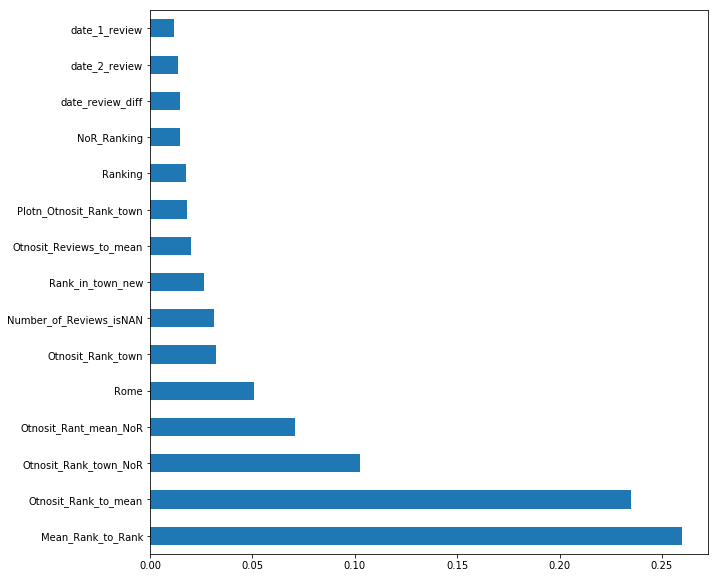

In [68]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [69]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,Number_of_Reviews_isNAN,Amsterdam,Athens,Barcelona,Berlin,Bratislava,...,Rank_in_town_new,Mean_Rank_Count_rest,Mean_Rank_to_Rank,Otnosit_Rank_town,Otnosit_Rank_to_mean,Otnosit_Reviews_to_mean,Plotn_Otnosit_Rank_town,Otnosit_Rank_town_NoR,Otnosit_Rant_mean_NoR,NoR_Ranking
3710,2425.0,0.0,75.197479,0.0,1,0,0,0,0,0,...,0.425979,1.197950,0.510302,-2.347531,-0.959624,0.000000,-21.788596,-176.528448,-72.161330,0.031009
6428,85.0,2.0,74.000000,0.0,0,0,0,0,0,0,...,5.741176,1.132315,6.500820,-0.174180,0.846173,-0.260032,-85.165295,-12.889344,62.616820,0.870588
4650,2270.0,2.0,35.000000,0.0,0,0,0,0,0,0,...,0.455066,1.197950,0.545146,-2.197483,-0.834370,-0.534559,-23.276364,-76.911907,-29.202949,0.015419
1512,1475.0,0.0,7.000000,0.0,0,0,0,0,0,0,...,0.692203,1.193988,0.826483,-1.444662,-0.209947,-0.955886,-23.103587,-10.112635,-1.469629,0.004746
8623,804.0,2.0,15.000000,0.0,0,0,0,0,0,0,...,0.733831,1.208860,0.887098,-1.362712,-0.127271,-0.758739,-91.980193,-20.440678,-1.909060,0.018657
5106,1396.0,2.0,8.000000,0.0,0,0,0,0,0,0,...,0.598854,1.162833,0.696367,-1.669856,-0.436025,-0.948145,-22.093169,-13.358852,-3.488199,0.005731
9278,6222.0,0.0,2.000000,0.0,0,0,0,0,1,0,...,0.434748,1.203482,0.523211,-2.300185,-0.911275,-0.968638,-17.764345,-4.600370,-1.822551,0.000321
773,265.0,1.0,24.000000,0.0,0,0,1,0,0,0,...,2.928302,1.134296,3.321562,-0.341495,0.698937,-0.744647,-47.197261,-8.195876,16.774484,0.090566
2344,9839.0,0.0,4.000000,0.0,0,0,0,0,0,0,...,0.731070,1.135786,0.830339,-1.367858,-0.204327,-0.971008,-41.678393,-5.471431,-0.817308,0.000407
175,5122.0,0.0,62.000000,0.0,0,0,0,0,0,0,...,0.505467,1.147444,0.579995,-1.978370,-0.724154,-0.786050,-11.273830,-122.658942,-44.897520,0.012105


In [70]:
test_data = test_data.drop(['Rating'], axis=1)

In [71]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [72]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [73]:
predict_submission

array([3.1  , 4.25 , 4.385, ..., 3.   , 4.46 , 4.395])

In [74]:
for i in range(len(predict_submission)):
    predict_submission[i] = rating(predict_submission[i])

In [75]:
predict_submission

array([3. , 4. , 4.5, ..., 3. , 4.5, 4.5])

In [76]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.0
7,id_7,2.5
8,id_8,4.5
9,id_9,4.5


In [77]:
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.0
7,id_7,2.5
8,id_8,4.5
9,id_9,4.5
